In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import backend as K 

In [0]:
tf.__version__

'1.15.0'

In [0]:
# Download roatated_MNIST dataset from https://sites.google.com/a/lisa.iro.umontreal.ca/public_static_twiki/variations-on-the-mnist-digits
# and store the data on Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Google drive path
path_data = '/content/gdrive/My Drive/Research/Dataset/MNIST'
path_save = '/content/gdrive/My Drive/Research/Codes/Models'
path_info = '/content/gdrive/My Drive/Research/Codes/Info'

In [0]:
# mnist_train = np.loadtxt(path_data+'/mnist_train.amat')
# mnist_test = np.loadtxt(path_data+'/mnist_test.amat')
mnist_rot_train = np.loadtxt(path_data+'/mnist_rot_train.amat')
mnist_rot_test = np.loadtxt(path_data+'/mnist_rot_test.amat')
# mnist_rot_background_train = np.loadtxt(path_data+'/mnist_rot_background_train.amat')
# mnist_rot_background_test = np.loadtxt(path_data+'/mnist_rot_background_test.amat')

In [0]:
mnist_rot = np.vstack((mnist_rot_train, mnist_rot_test))

In [0]:
print(mnist_rot.shape) 

(62000, 785)


In [0]:
## Use 0, 1, 2 labels only
## 0, 1, 2 represent bradykinesia, balanced, dyskinesia, respectively
xx0 = mnist_rot[mnist_rot[:,-1]==0][:,0:784].reshape(-1,28,28,1).astype(float)
xx1 = mnist_rot[mnist_rot[:,-1]==1][:,0:784].reshape(-1,28,28,1).astype(float)
xx2 = mnist_rot[mnist_rot[:,-1]==2][:,0:784].reshape(-1,28,28,1).astype(float)
print(xx0.shape, xx1.shape, xx2.shape)

(6183, 28, 28, 1) (7047, 28, 28, 1) (6229, 28, 28, 1)


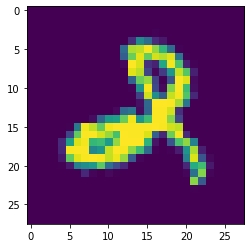

In [0]:
plt.imshow(xx2[2,:,:,0])

In [0]:
nClass = 3
nPat = 30
nY_PD = np.zeros((nPat,nClass), dtype=int)

In [0]:
# Number of labels for each patient
# e.g.) The first patient has 385 min of "Bradykinesia" data, 385 min of "Balanced" data, and no "Dyskinesia" data, 
nY_PD[:,0] = [385, 81, 97, 29, 136, 87, 62, 59, 163, 0, 0, 99, 220, 160, 42, 12, 54, 0, 16, 96, 88, 230, 0, 36, 0, 65, 2, 81, 3, 0]
nY_PD[:,1] = [14, 142, 27, 531, 119, 314, 224, 19, 178, 412, 0, 273, 197, 199, 355, 83, 71, 0, 27, 0, 285, 0, 8, 83, 39, 52, 106, 42, 10, 5]
nY_PD[:,2] = [0, 239, 144, 0, 182, 123, 166, 356, 218, 13, 162, 3, 0, 0, 36, 242, 0, 54, 96, 0, 0, 0, 138, 0, 317, 39, 0, 0, 0, 15]

In [0]:
# Make 30 patient data by stacking three-class images
X_list = []
Y_list = []
nTemp = np.zeros(nClass, dtype=int)
for ii in range(nPat):
  X_list.append(np.vstack((xx0[nTemp[0]:nTemp[0]+nY_PD[ii,0]], xx1[nTemp[1]:nTemp[1]+nY_PD[ii,1]], xx2[nTemp[2]:nTemp[2]+nY_PD[ii,2]])))
  Y_list.append(np.hstack((np.ones(nY_PD[ii,0], dtype=int)*0, np.ones(nY_PD[ii,1], dtype=int)*1, np.ones(nY_PD[ii,2], dtype=int)*2)))
  nTemp[0] += nY_PD[ii,0]
  nTemp[1] += nY_PD[ii,1]
  nTemp[2] += nY_PD[ii,2]

In [0]:
# Check the number of data for each patient
nDataPat = np.zeros(nPat, dtype=int)
for ii in range(nPat):
  nDataPat[ii] = X_list[ii].shape[0]
nDataPat

array([399, 462, 268, 560, 437, 524, 452, 434, 559, 425, 162, 375, 417,
       359, 433, 337, 125,  54, 139,  96, 373, 230, 146, 119, 356, 156,
       108, 123,  13,  20])

## Proposed ensemble CNN method (https://arxiv.org/abs/1808.02870)


In [0]:
nModels = 100
nHalfPat = (int)(nPat/2)

In [0]:
## Randomly split patinents into two groups in 100 times 
# trainPat = np.zeros((nModels, nHalfPat), dtype=int)
# testPat = np.zeros((nModels,nHalfPat), dtype=int)
# for ii in range(nModels):
#   temp = np.random.permutation(nPat)
#   trainPat[ii,:] = temp[0:nHalfPat]
#   testPat[ii,:] = temp[nHalfPat:]

In [0]:
trainPat = np.load(path_info+'/trainPat.npy')
testPat = np.load(path_info+'/testPat.npy')

In [0]:
# How many times a patient is included in the test sets
CountPatInTest = np.zeros(nPat, dtype=int)
for ii in range(nPat):
  CountPatInTest[ii] = np.sum(testPat==ii)
CountPatInTest

array([53, 51, 54, 46, 48, 50, 50, 43, 51, 48, 44, 44, 45, 44, 44, 53, 42,
       46, 55, 46, 51, 55, 56, 56, 49, 51, 51, 57, 54, 63])

In [0]:
# np.save(path_info+'/trainPat', trainPat)
# np.save(path_info+'/testPat', testPat)

In [0]:
input_shape = (28,28,1)
nEpoch = 50
nBatch = 128

In [0]:
# My simple CNN model
def MyModel():
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3),
                  activation='relu',
                  input_shape=input_shape))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(nClass, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])
  return model

In [0]:
hist_list = []
model_list = []
for ii in range(nModels):
  model_list.append(MyModel())
  nTrain = 0
  nTest = 0
  for jj in range(nHalfPat):
    nTrain += nDataPat[trainPat[ii,jj]]
    nTest += nDataPat[testPat[ii,jj]]
  xx_train = np.zeros((nTrain, 28, 28, 1))
  # yy_train = np.zeros((nTrain, 3))
  yy_train_vec = np.zeros(nTrain)
  xx_test = np.zeros((nTest, 28, 28, 1))
  # yy_test = np.zeros((nTest, 3))
  yy_test_vec = np.zeros(nTest)
  
  pp = 0; qq = 0;
  for jj in range(nHalfPat):
    xx_train[pp:pp+nDataPat[trainPat[ii,jj]]] = X_list[trainPat[ii,jj]]
    yy_train_vec[pp:pp+nDataPat[trainPat[ii,jj]]] = Y_list[trainPat[ii,jj]]
    xx_test[qq:qq+nDataPat[testPat[ii,jj]]] = X_list[testPat[ii,jj]]
    yy_test_vec[qq:qq+nDataPat[testPat[ii,jj]]] = Y_list[testPat[ii,jj]]
    pp += nDataPat[trainPat[ii,jj]]
    qq += nDataPat[testPat[ii,jj]]
  yy_train = tf.keras.utils.to_categorical(yy_train_vec, num_classes=nClass)
  yy_test = tf.keras.utils.to_categorical(yy_test_vec, num_classes=nClass)
  hist_list.append(model_list[ii].fit(xx_train, yy_train, batch_size=nBatch, epochs=nEpoch, verbose=0, validation_data=(xx_test, yy_test)))
  model_savename = "/ensem_{}.h5".format(ii)
  model_list[ii].save_weights(path_save+model_savename)

In [0]:
myHist = np.zeros((nEpoch,2,nModels))
for ii in range(nModels):
  myHist[:,0,ii]= hist_list[ii].history['acc']
  myHist[:,1,ii]= hist_list[ii].history['val_acc']

In [0]:
np.save(path_info+'/trainingResult_ensem', myHist)

In [0]:
np.isin(testPat[0], 27).any()

False

In [0]:
# Find training models for ensemble
trainModel_list = []
nEnsembleForPat = np.zeros(nPat, dtype=int)
for ii in range(nPat):
  trainModel_list.append([])
  for jj in range(nModels):
    if np.isin(testPat[ii], jj).any():
      trainModel_list[ii].append(jj)
      nEnsembleForPat[ii] += 1

In [0]:
# Test with the ensemble models
Y_pred_list = []
for ii in range(nPat):
  Y_pred_list.append(np.zeros((nEnsembleForPat[ii], nDataPat[ii])))
  for jj in range(nEnsembleForPat[ii]):
    yy_pred = model_list[trainModel_list[ii][jj]].predict_classes(X_list[ii])
    Y_pred_list[ii][jj,:] = yy_pred

In [0]:
acc_ensem = np.zeros(nPat) # Ensemble performance
acc_avg = np.zeros(nPat) # Average performance

In [0]:
for ii in range(nPat):
  acc_temp = np.zeros(nEnsembleForPat[ii])
  for jj in range(nEnsembleForPat[ii]):
    acc_temp[jj] = np.sum(Y_pred_list[ii][jj,:] == Y_list[ii])/nDataPat[ii]
  acc_avg[ii] = np.mean(acc_temp)
  
  Y_pred_ensem = np.zeros(len(Y_list[ii]))
  for kk in range(len(Y_list[ii])):
    Y_pred_ensem[kk] = np.argmax(np.bincount(Y_pred_list[ii][:,kk].astype(int)))
  acc_ensem[ii] = np.sum(Y_pred_ensem==Y_list[ii])/nDataPat[ii]

In [0]:
acc_avg

array([0.99348371, 0.98499278, 0.99353234, 0.99607143, 0.98733791,
       0.99173028, 0.98952802, 0.99231951, 0.99022063, 0.99733333,
       0.99176955, 0.99573333, 0.99472422, 0.99832869, 0.99060816,
       0.98951533, 0.9952    , 0.99259259, 0.97122302, 0.99652778,
       0.99553172, 0.99246377, 0.98858447, 0.99383754, 0.98014981,
       0.99316239, 0.99938272, 0.99295393, 1.        , 0.99      ])

In [0]:
acc_ensem

array([1.        , 0.99134199, 1.        , 1.        , 0.99542334,
       0.99427481, 0.99557522, 1.        , 0.99821109, 1.        ,
       1.        , 0.99733333, 1.        , 1.        , 0.99076212,
       1.        , 1.        , 1.        , 0.99280576, 1.        ,
       0.99463807, 1.        , 0.99315068, 0.99159664, 0.98876404,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [0]:
myHist[:,1,-1]

array([0.88181818, 0.90761673, 0.91867322, 0.93562651, 0.95970517,
       0.97027028, 0.96805894, 0.97813267, 0.9771499 , 0.97641277,
       0.97690415, 0.98009831, 0.97542995, 0.97592139, 0.97985256,
       0.97764128, 0.97592139, 0.97936118, 0.97911549, 0.97813267,
       0.98402947, 0.97960687, 0.9756757 , 0.97960687, 0.98083538,
       0.9771499 , 0.98206389, 0.98378378, 0.98058969, 0.9742015 ,
       0.98255527, 0.98230958, 0.97960687, 0.980344  , 0.98304671,
       0.9712531 , 0.97960687, 0.98083538, 0.97813267, 0.98353809,
       0.98280096, 0.98255527, 0.98009831, 0.98206389, 0.97788697,
       0.98206389, 0.98009831, 0.98255527, 0.98550367, 0.98280096])